In [1]:
from __future__ import absolute_import, division, print_function

# Data Exploration - continued

In this notebook I will continue to explore the data and ascertain their structure. 

This is followed by some preliminary machine learning.

## Imports

In [2]:
import os
import pickle
import time

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

## Read cleaned data from disk

In [3]:
cwd = os.getcwd()

In [4]:
df_2013 = pd.read_pickle(os.path.join(cwd,'data','df_2013_clean.df'))
df_2014 = pd.read_pickle(os.path.join(cwd,'data','df_2014_clean.df'))


## Geographical distribution of the data

In [5]:
df_2013['Yield'].describe()

count    177493.000000
mean         31.443024
std          15.214107
min           9.000000
25%          17.300000
50%          31.100000
75%          43.100000
max          72.200000
Name: Yield, dtype: float64

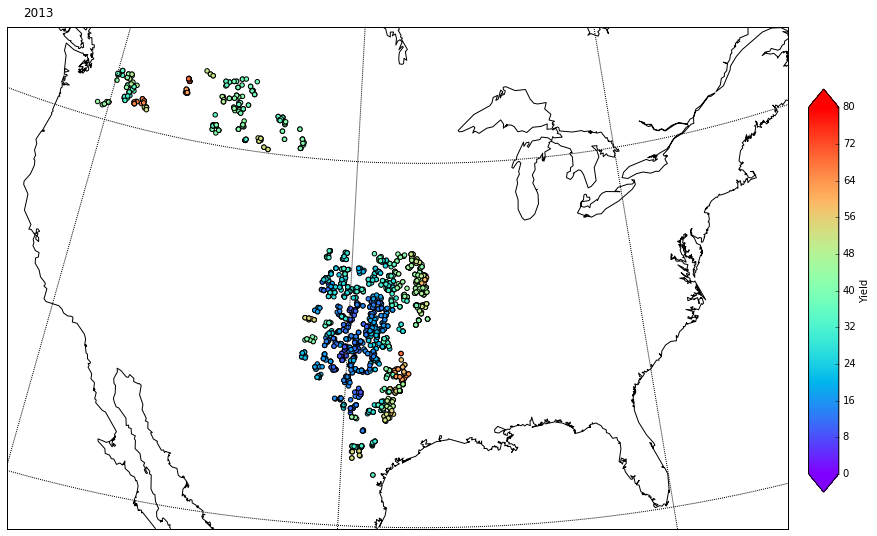

In [6]:
fig, ax = plt.subplots(figsize=(14, 14))

redraw = True
if redraw:
    # Map some of the yields to see where we are..
    # Use a Lambert Conformal map for now
    # Resolution: 'l'ow, 'h'high
    # good overview of features:
    # http://introtopython.org/visualization_earthquakes.html
    mymap = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64,
                    urcrnrlat=49, projection='lcc', lat_1=33, lat_2=45,
                    lon_0=-95, area_thresh=10000,
                    resolution = 'l',)
    # Basemap setup taking long. Pickel and reuse unless changes have been made
    pickle.dump(mymap,open('mymap.pickle','wb'),-1)  # pickle it 
else:
    pickle.load(open('mymap.pickle','rb'))


lng = np.array(df_2013[['Longitude']].iloc[::100,:])
lat = np.array(df_2013[['Latitude']].iloc[::100,:])
yld = np.array(df_2013[['Yield']].iloc[::100,:])
x,y = mymap(lng, lat)

im1 = mymap.scatter(x, y, c=yld, vmin=0, vmax=80, cmap=mpl.cm.get_cmap('rainbow'), zorder=2)

mymap.drawparallels(np.arange(25,65,20))
mymap.drawmeridians(np.arange(-120,-40,20))
mymap.drawcoastlines()

ax.annotate('2013', xy=(0.02, 1.02), fontsize=12,xycoords='axes fraction')

cax1 = fig.add_axes([0.92, 0.3, 0.03, 0.4])
cbar = plt.colorbar(im1,cax=cax1, orientation='vertical', extend='both', use_gridspec=True)
cbar.set_label('Yield')


So it appears that the data are roughly from two different geographical areas. In the southern area there is an interesting structure in the distribution of the yields.

## Drop features/columns

Drop additional columns:

* CountyName
* State
* Date

as per the instructions of the exercise. ("Please exclude CountyName, State, and Date from training as this will result in overfitting and lack of generalization to other states.")

In [7]:
drop_vec = ['CountyName', 'State', 'Date']
for drop_col in drop_vec:
    if drop_col in df_2013.columns:
        df_2013.drop(drop_col, axis=1, inplace=True)
    if drop_col in df_2014.columns:
        df_2014.drop(drop_col, axis=1, inplace=True)


## Scatter matrix

Explore the scatter matrix from all remaining columns. This can yield important insights into the data.

In [8]:
df_new = df_2013.sample(n=100)

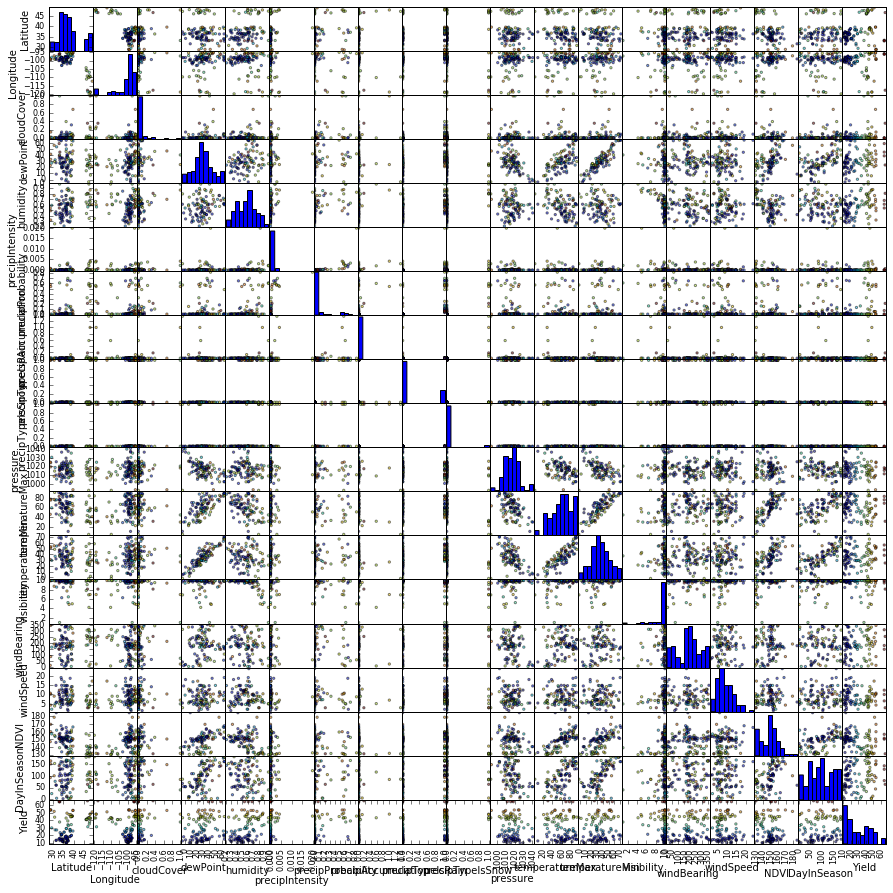

In [9]:
import matplotlib.cm as cm
# Below, 'c' gives the values that should be mapped onto a colormap 'cmap'.
# http://stackoverflow.com/questions/28752727/map-values-to-colors-in-matplotlib
pd.scatter_matrix(df_new, diagonal='hist', figsize=(15, 15),
                  c=df_new['Yield'].tolist(), cmap=cm.get_cmap('jet'));

## Multi-collinearity

There is significant multi-collinearity in the data. This can be seen from the correlation matrix (reproduced below) as well as from the scatter matrix plot (see above).

In [10]:
# Find all column pairs with correlation coefficients above a certain threshold
X = df_2013.corr()
limit = 0.65
index = X.index.tolist()
n = len(index)
newDF = pd.DataFrame(columns=['col1','col2','corr','corr col1 with target', 'corr col2 with target'])
pos = 0
for nidx,idx in enumerate(index):
    for k in range(n):
        if (k > nidx):
            value = X[idx].iloc[k]
        else:
            value = 0.0
        if value >= limit:
            corr_col1 = X['Yield'].loc[idx]
            corr_col2 = X['Yield'].loc[index[k]]
            newDF.loc[pos] = [idx, index[k] , value, corr_col1, corr_col2]
            pos += 1
newDF

,col1,col2,corr,corr col1 with target,corr col2 with target
0,dewPoint,temperatureMax,0.792366,0.011607,-0.152702
1,dewPoint,temperatureMin,0.910333,0.011607,-0.060512
2,precipProbability,precipTypeIsRain,0.709446,0.111940,0.108773
3,temperatureMax,temperatureMin,0.886946,-0.152702,-0.060512
4,temperatureMax,NDVI,0.784945,-0.152702,-0.170673
5,temperatureMin,NDVI,0.674792,-0.060512,-0.170673
6,temperatureMin,DayInSeason,0.684064,-0.060512,-0.001171


Usually, the presence of collinearity would make it difficult to clearly identify which features are most relevant for driving the outcome (here: 'Yield'). However, for the task at hand we are only interested in predicting the outcome as reliably as possible. Therefore all data can be used for modeling. Regularization methods may be employed as well to help address the collinearity.

## Feature encoding

While the dataset includes some binary features ('precipTypeIsRain', 'precipTypeIsSnow'), it does not include any obvious multi-level categorical or ordinal features. Additional encoding (e.g., OneHotEncoding) is therefore not necessary at this point. 

## Train-Test split

In [11]:
# train_test_split splits randomly, i.e., shuffled. See docs:
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
y = df_2013['Yield']
X = df_2013.drop('Yield',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature scaling

The dataset contains a number of numerical features which are on very different scales. Set up a scaler to bring all features to zero mean and unity standard deviation. Later we need to apply the scaler also to the test set.

In [12]:
from sklearn import preprocessing
columns_to_scale = ['Latitude',
    'Longitude',
    'cloudCover',
    'dewPoint',
    'humidity',
    'precipIntensity',
    'precipProbability',
    'precipAccumulation',
#     'precipTypeIsRain,
#     'precipTypeIsSnow,
    'pressure',
    'temperatureMax',
    'temperatureMin',
    'visibility',
    'windBearing',
    'windSpeed',
    'NDVI',
    'DayInSeason',]

std_scaler = preprocessing.StandardScaler().fit(X_train[columns_to_scale])
X_train[columns_to_scale] = std_scaler.transform(X_train[columns_to_scale])




/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
# Don't forget to apply the scaler also to the test set.
X_test[columns_to_scale] = std_scaler.transform(X_test[columns_to_scale])


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## First modeling

I will now explore a number of regression algorithms. Their performance when compared to each other may give a first indication on what the most promising algorithms for the dataset are. I can then focus on these to furtehr optimize the hyperparameters.

For now, I include the following algorithms:

* linear regression (<a href="http://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares">Sklearn</a>)
* linear regression with L2 regularization (<a href="http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression">Sklearn</a>)
* polynomial regression (<a href="http://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions">Sklearn</a>)
* random forest regression (<a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor">Sklearn</a>)
* gradient boosted tree regression (<a href="http://scikit-learn.org/stable/modules/ensemble.html#regression">Sklearn</a>)
* nearest neighbor regression (<a href="http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression">Sklearn</a>)
* support vector regression (<a href="http://scikit-learn.org/stable/modules/svm.html#regression">Sklearn</a>)

All algorithm are first run using their default values.

In [18]:
# Use cros validation. Set 'k' and the scoring function. If scoring function is not set, 
# cross_val_score will use the default scoring for the respective estimator. To make sure 
# I compare all estimators on the same scale, I set the scoring function explicitly.
from sklearn.model_selection import cross_val_score
cv_k = 5
cv_scoring = 'neg_mean_squared_error'
# cv_scoring = 'r2'

The data are grouped by county and ordered by time. For a reliable training and testing scenario, the data will have to be shuffled.

In [19]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=cv_k, shuffle=True)

In [20]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR

In [21]:
# Linear regression
now = time.time()
est = linear_model.LinearRegression()
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: -179.99 (+/- 2.87)
Exec. time:  1.01 s


In [22]:
# Linear regression with L2 regularization
now = time.time()
est = linear_model.Ridge(alpha = 1.0)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: -179.96 (+/- 3.58)
Exec. time:  0.77 s


In [23]:
# Polynomial regression
now = time.time()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
est = linear_model.LinearRegression()
scores = cross_val_score(est, X_train_poly, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))


Accuracy: -111.52 (+/- 1.20)
Exec. time: 18.70 s


In [24]:
# Polynomial regression with regularization
now = time.time()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
est = linear_model.Ridge(alpha = 1.0)
scores = cross_val_score(est, X_train_poly, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))



Accuracy: -111.52 (+/- 1.43)
Exec. time:  5.65 s


In [25]:
# Random forest regression
now = time.time()
est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: -0.0050 (+/- 0.0070)
Exec. time: 17.76 s


Check the feature importance determined from the random forest regressor:

In [26]:
feature_names = X_train.columns
est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
est.fit(X_train, y_train)
features = zip(feature_names,est.feature_importances_)
for feature in features:
    print(feature)

('Latitude', 0.23348389751942511)
('Longitude', 0.76630715800800719)
('cloudCover', 0.00020745671781997516)
('dewPoint', 7.9382689034818354e-07)
('humidity', 1.0395163640081696e-07)
('precipIntensity', 0.0)
('precipProbability', 0.0)
('precipAccumulation', 0.0)
('precipTypeIsRain', 0.0)
('precipTypeIsSnow', 0.0)
('pressure', 0.0)
('temperatureMax', 0.0)
('temperatureMin', 1.6365119215859352e-07)
('visibility', 0.0)
('windBearing', 0.0)
('windSpeed', 1.3581925373175123e-07)
('NDVI', 2.9050577503802775e-07)
('DayInSeason', 0.0)


Latitude and espacially Longitude seem VERY important. Let's see what happens to the error and feature importance if I drop these two features:

In [28]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train_rf.drop('Longitude', axis=1, inplace=True)
X_train_rf.drop('Latitude', axis=1, inplace=True)
feature_names = X_train_rf.columns
est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
est.fit(X_train_rf, y_train_rf)
features = zip(feature_names,est.feature_importances_)
for feature in features:
    print(feature)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


('cloudCover', 0.032881554961770629)
('dewPoint', 0.090416566815144997)
('humidity', 0.082316298921980072)
('precipIntensity', 0.018656614519612973)
('precipProbability', 0.014125164008506465)
('precipAccumulation', 0.0039441313619068396)
('precipTypeIsRain', 0.0020674138065998856)
('precipTypeIsSnow', 0.00040685202860069801)
('pressure', 0.11598585571060445)
('temperatureMax', 0.099179897684422452)
('temperatureMin', 0.07829443762777509)
('visibility', 0.051418520203861694)
('windBearing', 0.11429790658902546)
('windSpeed', 0.094003475379380724)
('NDVI', 0.094670399208633738)
('DayInSeason', 0.10733491117217384)


In [29]:
# Gradient boosted regression
now = time.time()
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                max_depth=0.3, random_state=0, loss='ls')
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

# from sklearn.metrics import mean_squared_error
# mean_squared_error(y_test, est.predict(X_test))    


Accuracy: -231.4858 (+/- 2.6968)
Exec. time:  2.61 s


In [30]:
# Nearest neighbor regression
now = time.time()
n_neighbors = 5
weight = 'uniform' # 'distance'
est = neighbors.KNeighborsRegressor(n_neighbors, weights=weight, n_jobs=-1)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))



Accuracy: -39.10 (+/- 1.03)
Exec. time: 246.07 s


Support vector classifiers scale more than quadratically with the number of samples. From the documentation: "The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples." <a href"http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html">source</a>

I assume the same goes for SV regressors. The current dataset has a lot of samples (>100k per year), making quick SV exploration unfeasible. The only way is to limit the number of samples. This makes it difficult to compare results with other classifiers that use the full data set.

In [31]:
# Reduce size of dataset
idx = np.random.choice(len(X_train), size=10000, replace=False)
X_train_part = X_train.iloc[idx]
y_train_part = y_train.iloc[idx]

In [ ]:
# Support vector regression - RBF kernel
now = time.time()
est = SVR(kernel='rbf', C=1, gamma=0.1)
scores = cross_val_score(est, X_train_part, y_train_part, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

In [ ]:
# Support vector regression - linear kernel
now = time.time()
est = SVR(kernel='linear', C=1)
scores = cross_val_score(est, X_train_part, y_train_part, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

In [ ]:
# Support vector regression - polynomial kernel
# This takes much longer than the previous two SVR methods.
# Reduce size of dataset even further
idx = np.random.choice(len(X_train), size=1000, replace=False)
X_train_part = X_train.iloc[idx]
y_train_part = y_train.iloc[idx]
now = time.time()
est = SVR(kernel='poly', C=1e3, degree=2)
scores = cross_val_score(est, X_train_part, y_train_part, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

In [ ]:
# Crashes due to memory issues when using the full data (-> 140k rows)
#
idx = np.random.choice(len(X_train), size=10000, replace=False)
X_train_part = X_train.iloc[idx]
y_train_part = y_train.iloc[idx]
#
from sklearn.kernel_ridge import KernelRidge
now = time.time()
est = KernelRidge(kernel='rbf', gamma=0.1)
scores = cross_val_score(est, X_train_part, y_train_part, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

To establish some comparison, re-run random forest with the reduced data set.

In [ ]:
# Random forest regression
now = time.time()
est = RandomForestRegressor(n_estimators=10)
scores = cross_val_score(est, X_train_part, y_train_part, cv=10, scoring=cv_scoring)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

## Looking further into the random forest regressor

The random forest regressor above shows the best performance (by far!). This is a bit suspicious....

In [32]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
feature_names = X_train_rf.columns
est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
est.fit(X_train_rf, y_train_rf)
features = zip(feature_names,est.feature_importances_)
for feature in features:
    print(feature)

('Latitude', 0.23469220284626108)
('Longitude', 0.76510120353413025)
('cloudCover', 0.00020505076971865971)
('dewPoint', 0.0)
('humidity', 4.6058596647150502e-07)
('precipIntensity', 0.0)
('precipProbability', 0.0)
('precipAccumulation', 0.0)
('precipTypeIsRain', 0.0)
('precipTypeIsSnow', 0.0)
('pressure', 6.5807782968073967e-07)
('temperatureMax', 0.0)
('temperatureMin', 1.8169017853453218e-07)
('visibility', 0.0)
('windBearing', 0.0)
('windSpeed', 2.0619148646602611e-07)
('NDVI', 3.6304428805560311e-08)
('DayInSeason', 0.0)


Inspecting the feature importance it becomes clear that 'Longitude' and 'Latitude' dominate the feature space significantly. The question is, should Longitude and Latitude even stay in the model? Since other local indicators were specifically excluded as per the instructions ("Please exclude CountyName, State, and Date from training as this will result in overfitting and lack of generalization to other states."

In [33]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train_rf.drop('Longitude', axis=1, inplace=True)
X_train_rf.drop('Latitude', axis=1, inplace=True)
feature_names = X_train_rf.columns
est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
est.fit(X_train_rf, y_train_rf)
features = zip(feature_names,est.feature_importances_)
for feature in features:
    print(feature)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


('cloudCover', 0.034939781839249867)
('dewPoint', 0.084385197512963098)
('humidity', 0.07875337323433991)
('precipIntensity', 0.017418949937117227)
('precipProbability', 0.014246495938835663)
('precipAccumulation', 0.0038256794197375392)
('precipTypeIsRain', 0.0017611476250349914)
('precipTypeIsSnow', 0.00032281556574562874)
('pressure', 0.11684408128368204)
('temperatureMax', 0.099936092215842848)
('temperatureMin', 0.081931190977637541)
('visibility', 0.050865523157116878)
('windBearing', 0.11605662295979555)
('windSpeed', 0.09452651208417602)
('NDVI', 0.098678717796018112)
('DayInSeason', 0.10550781845270714)


## Tuning the gradient boosted tree regressor

The GBT rgressor - the recent favorite among many machine-learning competitions - performed rather poorly compared to the random forest regressor. Obviously, I did not perform any parameter tuning, but rather used the default values. Now let's see if we can increase the performance by tuning some of the main parameters:

In [34]:
# Gradient boosted regression - with hyperparameter tuning
from sklearn.model_selection import GridSearchCV
now = time.time()
# Set the parameters by cross-validation

tuned_parameters = [{'n_estimators': [1000], 
                     'max_depth': [3,5], 
                    'learning_rate': [0.1,1]}]


est_base = GradientBoostingRegressor(random_state=0, loss='ls')

est = GridSearchCV(est_base, tuned_parameters, cv=kf, scoring=cv_scoring, n_jobs=-1)

est.fit(X_train, y_train)

means = est.cv_results_['mean_test_score']
stds = est.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, est.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
    
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))



Process PoolWorker-2:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/pool.py", line 113, in worker
    result = (True, func(*args, **kwds))
KeyboardInterrupt
Process PoolWorker-5:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **

KeyboardInterrupt: 

These are some of the results from a step-by-step grid search. Scoring metric was neg_mean_squared_error (closer to zero is better):

-153.987 (+/-2.428) for {'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 1}<br>Exec. time:  9.60 s<br>
 -74.007 (+/-0.505) for {'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 3}<br>Exec. time: 27.22 s<br>
 -49.392 (+/-0.467) for {'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 5}<br>
 -61.790 (+/-0.489) for {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 1}<br>Exec. time: 64.59 s<br>
 -15.438 (+/-0.824) for {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}<br>
 -2.845 (+/-0.157) for {'n_estimators': 100, 'learning_rate': 0.5, 'max_depth': 3}<br>Exec. time: 93.44 s<br>
 -0.077 (+/-0.018) for {'n_estimators': 100, 'learning_rate': 0.5, 'max_depth': 5}<br>Exec. time: 130.01 s<br>
 -0.029 (+/-0.040) for {'n_estimators': 100, 'learning_rate': 1, 'max_depth': 5}<br>Exec. time: 122.06 s<br>
 -3.531 (+/-0.283) for {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5}<br>
-40.835 (+/-0.520) for {'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 1}<br>Exec. time: 244.98 s<br>
-0.870 (+/-0.091) for {'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 3}<br>Exec. time: 649.93 s<br>

With some tuning of the hyperparameters the regression performance of the gradient boosted tree as measured by cross-validation is comparably low to the random forest performance.

Now I have to test the baias-variance trade off for these well performing models.

## Folding the algorithm search into one class/function (work in progress...)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR    

    
def run_linear(X, y,):
    est = linear_model.LinearRegression()

def run_ridge(X, y, alpha=None)
    if alpha is None:
        est = linear_model.Ridge()
    else:
        est = linear_model.Ridge(alpha = alpha)

def run_rfr(X, y, n_estimators=None, n_jobs=-1, random_state=0):
    if n_estimators is None:
        est = RandomForestRegressor(n_jobs=n_jobs, random_state=random_state)
    else:
        est = RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs,
                                    random_state=random_state)

def run_gbr(X, y, n_estimators=None, learning_rate=None, 
            max_depth=None, random_state=0):
    fit_params = {'n_estimators': n_estimators, 
                  'learning_rate': learning_rate,
                  'max_depth': max_depth}
    fit_params = {key: value for key, value in fit_params.items() 
         if value is not None}
    if len(fit_params.keys()) == 0:
        est = GradientBoostingRegressor(random_state=0)
    else:
        est = GradientBoostingRegressor(random_state=0, **fit_params)

def run_knn(X, y, n_neighbors=None, n_jobs=-1):
    if n_neighbors is None:
        est = neighbors.KNeighborsRegressor(n_jobs=n_jobs)
    else:
        est = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors, 
                                            weights=weight, n_jobs=-1)


def algo_test_suite(X_in, y_in, cv_k=5, cv_scoring=None):
    """
    Test a number of algorithms and compare their performance.
    """
    kf = KFold(n_splits=cv_k, shuffle=True)

    poly = PolynomialFeatures(degree=2)
    X_in_poly = poly.fit_transform(X_in)

    algo_dict = {'Linear': run_linear(X_in, y_in),
                 'Ridge': run_ridge(X_in, y_in),
                 'Polynomial linear': run_linear(X_in_poly, y_in), 
                 'Polynomial ridge': run_ridge(X_in_poly, y_in),
                 'Random forest': run_rfr(X_in, y_in),
                 'Gradient boosted': run_gbr(X_in, y_in), 
                 'kNN': run_knn(X_in, y_in),}
    
    for algo in algo_dict.keys():
        
    
    
    scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)


print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

            
            
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)

            
    
    kf = KFold(n_splits=cv_k, shuffle=True)
    
    
    
    
    
    
    
# Linear regression
now = time.time()
est = linear_model.LinearRegression()
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))  
  
# Linear regression with L2 regularization
now = time.time()
est = linear_model.Ridge(alpha = 1.0)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))


# Polynomial regression
now = time.time()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
est = linear_model.LinearRegression()
scores = cross_val_score(est, X_train_poly, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))


# Polynomial regression with regularization
now = time.time()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
est = linear_model.Ridge(alpha = 1.0)
scores = cross_val_score(est, X_train_poly, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))



# Random forest regression
now = time.time()
est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

# Gradient boosted regression
now = time.time()
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                max_depth=0.3, random_state=0, loss='ls')
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

# from sklearn.metrics import mean_squared_error
# mean_squared_error(y_test, est.predict(X_test))    


# Nearest neighbor regression
now = time.time()
n_neighbors = 5
weight = 'uniform' # 'distance'
est = neighbors.KNeighborsRegressor(n_neighbors, weights=weight, n_jobs=-1)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))



    

## Learning curves

Explore learning curves to investigate potential over/under fitting.

In [ ]:
now = time.time()
n_total = len(X_train)
training_sizes = np.logspace(2,np.log10(n_total),10)
cross_val_scores = []
train_scores = []
for tmp_size in training_sizes:
    idx = np.random.choice(len(X_train), size=tmp_size, replace=False)
    X_train_part = X_train.iloc[idx]
    y_train_part = y_train.iloc[idx]
    est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
    scores = cross_val_score(est, X_train_part, y_train_part, cv=kf, scoring=cv_scoring)
    cross_val_scores.append(scores.mean())
    est.fit(X_train_part, y_train_part)
    train_scores.append(mean_squared_error(y_train_part,est.predict(X_train_part)))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))    
    





In [ ]:
for i in range(len(cross_val_scores)):
    print('{} - {}'.format(cross_val_scores[i],train_scores[i]))



In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
title = "Learning Curve (Random Forest)"
plt.title(title)
plt.grid()
plt.plot(training_sizes,train_scores, 'o-', color="r",
         label="Training score")
plt.plot(training_sizes,[-x for x in cross_val_scores], 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best");




In [ ]:
X_train_rf = X_train.drop('Longitude', axis=1)
X_train_rf = X_train.drop('Latitude', axis=1)
#
now = time.time()
n_total = len(X_train_rf)
training_sizes = np.logspace(2,np.log10(n_total),10)
cross_val_scores = []
train_scores = []
for tmp_size in training_sizes:
    idx = np.random.choice(len(X_train_rf), size=tmp_size, replace=False)
    X_train_part = X_train_rf.iloc[idx]
    y_train_part = y_train.iloc[idx]
    est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
    scores = cross_val_score(est, X_train_part, y_train_part, cv=kf, scoring=cv_scoring)
    cross_val_scores.append(scores.mean())
    est.fit(X_train_part, y_train_part)
    train_scores.append(mean_squared_error(y_train_part,est.predict(X_train_part)))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))    
    



In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
title = "Learning Curve (Random Forest)"
plt.title(title)
# plt.plot(training_sizes,train_scores,label='Training')
# plt.plot(training_sizes,cross_val_scores,label='Cross validation')
plt.grid()

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.1,
#                  color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(training_sizes,train_scores, 'o-', color="r",
         label="Training score")
plt.plot(training_sizes,[-x for x in cross_val_scores], 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best");



In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X, y = X_train, y_train


title = "Learning Curve (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
plot_learning_curve(est, title, X, y, ylim=(-1, 1.0), cv=kf, n_jobs=-1)


plt.show()

## Source code used in sklearn's 'plot_learning_curve'

Copied to investigate what is going on behind the scenes....

In [ ]:
# scikit-learn/sklearn/model_selection/_validation.py source

def _fit_and_score(estimator, X, y, scorer, train, test, verbose,
                   parameters, fit_params, return_train_score=False,
                   return_parameters=False, return_n_test_samples=False,
                   return_times=False, error_score='raise'):
    """Fit estimator and compute scores for a given dataset split.
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    scorer : callable
        A scorer callable object / function with signature
        ``scorer(estimator, X, y)``.
    train : array-like, shape (n_train_samples,)
        Indices of training samples.
    test : array-like, shape (n_test_samples,)
        Indices of test samples.
    verbose : integer
        The verbosity level.
    error_score : 'raise' (default) or numeric
        Value to assign to the score if an error occurs in estimator fitting.
        If set to 'raise', the error is raised. If a numeric value is given,
        FitFailedWarning is raised. This parameter does not affect the refit
        step, which will always raise the error.
    parameters : dict or None
        Parameters to be set on the estimator.
    fit_params : dict or None
        Parameters that will be passed to ``estimator.fit``.
    return_train_score : boolean, optional, default: False
        Compute and return score on training set.
    return_parameters : boolean, optional, default: False
        Return parameters that has been used for the estimator.
    Returns
    -------
    train_score : float, optional
        Score on training set, returned only if `return_train_score` is `True`.
    test_score : float
        Score on test set.
    n_test_samples : int
        Number of test samples.
    fit_time : float
        Time spent for fitting in seconds.
    score_time : float
        Time spent for scoring in seconds.
    parameters : dict or None, optional
        The parameters that have been evaluated.
    """
    if verbose > 1:
        if parameters is None:
            msg = ''
        else:
            msg = '%s' % (', '.join('%s=%s' % (k, v)
                          for k, v in parameters.items()))
        print("[CV] %s %s" % (msg, (64 - len(msg)) * '.'))

    # Adjust length of sample weights
    fit_params = fit_params if fit_params is not None else {}
    fit_params = dict([(k, _index_param_value(X, v, train))
                      for k, v in fit_params.items()])

    if parameters is not None:
        estimator.set_params(**parameters)

    start_time = time.time()

    X_train, y_train = _safe_split(estimator, X, y, train)
    X_test, y_test = _safe_split(estimator, X, y, test, train)

    try:
        if y_train is None:
            estimator.fit(X_train, **fit_params)
        else:
            estimator.fit(X_train, y_train, **fit_params)

    except Exception as e:
        # Note fit time as time until error
        fit_time = time.time() - start_time
        score_time = 0.0
        if error_score == 'raise':
            raise
        elif isinstance(error_score, numbers.Number):
            test_score = error_score
            if return_train_score:
                train_score = error_score
            warnings.warn("Classifier fit failed. The score on this train-test"
                          " partition for these parameters will be set to %f. "
                          "Details: \n%r" % (error_score, e), FitFailedWarning)
        else:
            raise ValueError("error_score must be the string 'raise' or a"
                             " numeric value. (Hint: if using 'raise', please"
                             " make sure that it has been spelled correctly.)")

    else:
        fit_time = time.time() - start_time
        test_score = _score(estimator, X_test, y_test, scorer)
        score_time = time.time() - start_time - fit_time
        if return_train_score:
            train_score = _score(estimator, X_train, y_train, scorer)

    if verbose > 2:
        msg += ", score=%f" % test_score
    if verbose > 1:
        total_time = score_time + fit_time
        end_msg = "%s, total=%s" % (msg, logger.short_format_time(total_time))
        print("[CV] %s %s" % ((64 - len(end_msg)) * '.', end_msg))

    ret = [train_score, test_score] if return_train_score else [test_score]

    if return_n_test_samples:
        ret.append(_num_samples(X_test))
    if return_times:
        ret.extend([fit_time, score_time])
    if return_parameters:
        ret.append(parameters)
    return ret


In [ ]:
# scikit-learn/sklearn/model_selection/_validation.py source

def learning_curve(estimator, X, y, groups=None,
                   train_sizes=np.linspace(0.1, 1.0, 5), cv=None, scoring=None,
                   exploit_incremental_learning=False, n_jobs=1,
                   pre_dispatch="all", verbose=0):
    """Learning curve.
    Determines cross-validated training and test scores for different training
    set sizes.
    A cross-validation generator splits the whole dataset k times in training
    and test data. Subsets of the training set with varying sizes will be used
    to train the estimator and a score for each training subset size and the
    test set will be computed. Afterwards, the scores will be averaged over
    all k runs for each training subset size.
    Read more in the :ref:`User Guide <learning_curve>`.
    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.
    groups : array-like, with shape (n_samples,), optional
        Group labels for the samples used while splitting the dataset into
        train/test set.
    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross validation,
          - integer, to specify the number of folds in a `(Stratified)KFold`,
          - An object to be used as a cross-validation generator.
          - An iterable yielding train, test splits.
        For integer/None inputs, if the estimator is a classifier and ``y`` is
        either binary or multiclass, :class:`StratifiedKFold` is used. In all
        other cases, :class:`KFold` is used.
        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validation strategies that can be used here.
    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.
    exploit_incremental_learning : boolean, optional, default: False
        If the estimator supports incremental learning, this will be
        used to speed up fitting for different training set sizes.
    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    pre_dispatch : integer or string, optional
        Number of predispatched jobs for parallel execution (default is
        all). The option can reduce the allocated memory. The string can
        be an expression like '2*n_jobs'.
    verbose : integer, optional
        Controls the verbosity: the higher, the more messages.
    Returns
    -------
    train_sizes_abs : array, shape = (n_unique_ticks,), dtype int
        Numbers of training examples that has been used to generate the
        learning curve. Note that the number of ticks might be less
        than n_ticks because duplicate entries will be removed.
    train_scores : array, shape (n_ticks, n_cv_folds)
        Scores on training sets.
    test_scores : array, shape (n_ticks, n_cv_folds)
        Scores on test set.
    Notes
    -----
    See :ref:`examples/model_selection/plot_learning_curve.py
    <sphx_glr_auto_examples_model_selection_plot_learning_curve.py>`
    """
    if exploit_incremental_learning and not hasattr(estimator, "partial_fit"):
        raise ValueError("An estimator must support the partial_fit interface "
                         "to exploit incremental learning")
    X, y, groups = indexable(X, y, groups)

    cv = check_cv(cv, y, classifier=is_classifier(estimator))
    # Make a list since we will be iterating multiple times over the folds
    cv_iter = list(cv.split(X, y, groups))
    scorer = check_scoring(estimator, scoring=scoring)

    n_max_training_samples = len(cv_iter[0][0])
    # Because the lengths of folds can be significantly different, it is
    # not guaranteed that we use all of the available training data when we
    # use the first 'n_max_training_samples' samples.
    train_sizes_abs = _translate_train_sizes(train_sizes,
                                             n_max_training_samples)
    n_unique_ticks = train_sizes_abs.shape[0]
    if verbose > 0:
        print("[learning_curve] Training set sizes: " + str(train_sizes_abs))

    parallel = Parallel(n_jobs=n_jobs, pre_dispatch=pre_dispatch,
                        verbose=verbose)
    if exploit_incremental_learning:
        classes = np.unique(y) if is_classifier(estimator) else None
        out = parallel(delayed(_incremental_fit_estimator)(
            clone(estimator), X, y, classes, train, test, train_sizes_abs,
            scorer, verbose) for train, test in cv_iter)
    else:
        out = parallel(delayed(_fit_and_score)(
            clone(estimator), X, y, scorer, train[:n_train_samples], test,
            verbose, parameters=None, fit_params=None, return_train_score=True)
            for train, test in cv_iter
            for n_train_samples in train_sizes_abs)
        out = np.array(out)
        n_cv_folds = out.shape[0] // n_unique_ticks
        out = out.reshape(n_cv_folds, n_unique_ticks, 2)

    out = np.asarray(out).transpose((2, 1, 0))

    return train_sizes_abs, out[0], out[1]